In [1]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import matplotlib.pyplot as plt
import html
import pandas as pd
import seaborn as sns
from google.colab import files
import os
from datetime import timedelta

In [2]:
#Import modules
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
src_path_train = 'gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/Train/'
src_path_test = 'gdrive/Shareddrives/TCC_MLR-Guilherme_Vinicius/Notebooks/Files/Test/'

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1/255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.20)

test_datagen = ImageDataGenerator(rescale=1/255.0)

In [6]:
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)
valid_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=True,
    seed=42
)
test_generator = test_datagen.flow_from_directory(
    directory=src_path_test,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 339 images belonging to 3 classes.
Found 83 images belonging to 3 classes.
Found 50 images belonging to 3 classes.


In [7]:
# Importa função para fazer gráfico de RNAs
from tensorflow.keras.utils import plot_model
image_dim = (96,96,3)
# Carrega e salva a VGG16 excluindo suas camadas densas i
from tensorflow.keras.applications import VGG16
rna_base = VGG16(weights='imagenet', include_top=False, input_shape=image_dim)

# Mostra a arquitetura da VGG16
#rna_base.summary()

# Cria um arquivo com o esquema da VGG16
#plot_model(rna_base, to_file='VGG16.png', show_shapes=True)  

58889256/58889256 [==============================] - 0s 0us/step


In [8]:
# Importa do Keras classes de modelos e de camadas
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.constraints import max_norm
# Inicia RNA sequencial com a rna_base e adiciona as camadas de flattenning e densas
# Inclua seu código aqui
rna = models.Sequential()
rna.add(rna_base)
rna.add(layers.Flatten())
rna.add(layers.Dense(3, activation='softmax'))
# Visualização da arquitetura da rede
rna.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 3)                 13827     
                                                                 
Total params: 14,728,515
Trainable params: 14,728,515
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Número de parâmetros a serem treinados antes do congelamento
print('Número de parâmetros treináveis antes do congelamento =', len(rna.trainable_weights))
# Congelamento dos parâmetros da rna_base
rna_base.trainable = False
# Número de parâmetros a serem treinados após o congelamento
print('Número de parâmetros treináveis após o congelamento =', len(rna.trainable_weights))

Número de parâmetros treináveis antes do congelamento = 28
Número de parâmetros treináveis após o congelamento = 2


In [10]:
# Configuração do otimizador
from tensorflow.keras import optimizers
# Configuração do otimizador
adam = optimizers.Adam(learning_rate=0.001)
rna.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)
# Treinamento da RNA
history = rna.fit(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=10)

Epoch 1/10
10/10 [==============================] - 115s 11s/step - loss: 1.0019 - accuracy: 0.5244 - val_loss: 1.0044 - val_accuracy: 0.4219
Epoch 2/10
10/10 [==============================] - 32s 3s/step - loss: 0.7626 - accuracy: 0.7264 - val_loss: 1.0545 - val_accuracy: 0.4062
Epoch 3/10
10/10 [==============================] - 32s 3s/step - loss: 0.6528 - accuracy: 0.7687 - val_loss: 1.0185 - val_accuracy: 0.5156
Epoch 4/10
10/10 [==============================] - 33s 3s/step - loss: 0.5442 - accuracy: 0.7915 - val_loss: 1.1796 - val_accuracy: 0.4688
Epoch 5/10
10/10 [==============================] - 32s 3s/step - loss: 0.5039 - accuracy: 0.8502 - val_loss: 1.2199 - val_accuracy: 0.4844
Epoch 6/10
10/10 [==============================] - 33s 3s/step - loss: 0.4618 - accuracy: 0.8469 - val_loss: 0.9626 - val_accuracy: 0.5000
Epoch 7/10
10/10 [==============================] - 32s 3s/step - loss: 0.4290 - accuracy: 0.8664 - val_loss: 1.0615 - val_accuracy: 0.5156
Epoch 8/10
10/10 [

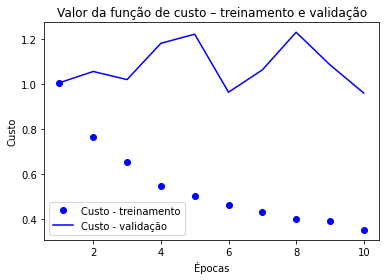

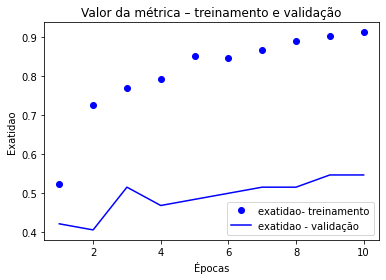

In [11]:
# Salva treinamento na variável history para visualização
history_dict = history.history

# Salva custos, métricas e epocas em vetores 
custo = history_dict['loss']
acc = history_dict['accuracy']
val_custo = history_dict['val_loss']
val_acc = history_dict['val_accuracy']

# Cria vetor de épocas
epocas = range(1, len(custo) + 1)

# Gráfico dos valores de custo
plt.plot(epocas, custo, 'bo', label='Custo - treinamento')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
plt.plot(epocas, acc, 'bo', label='exatidao- treinamento')
plt.plot(epocas, val_acc, 'b', label='exatidao - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [12]:
# Calcula a função de custo e a métrica para os dados de teste
custo_metrica_train = rna.evaluate(train_generator, steps=20) 
custo_metrica_val = rna.evaluate(valid_generator, steps=20) 
custo_metrica_test = rna.evaluate(test_generator, steps=20) 

11/20 [===============>..............] - ETA: 23s - loss: 0.3304 - accuracy: 0.9381

 3/20 [===>..........................] - ETA: 36s - loss: 1.0803 - accuracy: 0.5663

20/20 [==============================] - 8s 402ms/step - loss: 0.3495 - accuracy: 0.8000


In [13]:
# Descongela todas as camadas da rna_base
# Inclua seu código aqui
rna_base.trainable = True
set_trainable = False
# Percorre camadas da rna_base procurando pelo 5º bloco
# Inclua seu código aqui
for layer in rna_base.layers:
 if layer.name == 'block5_conv1':
  set_trainable = True

 if set_trainable:
  layer.trainable = True
 else:
  layer.trainable = False

print('Número de parâmetros treináveis após o descongelamento =', len(rna.trainable_weights))

Número de parâmetros treináveis após o descongelamento = 8


In [14]:
# Configuração do otimizador
# Inclua seu código aqui
adam = optimizers.Adam(lr=1e-05)
rna.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)
# Treinamento da RNA
# Inclua seu código aqui
history2 = rna.fit(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


10/10 [==============================] - 40s 4s/step - loss: 0.3304 - accuracy: 0.8893 - val_loss: 1.5922 - val_accuracy: 0.5312
Epoch 2/10
10/10 [==============================] - 39s 4s/step - loss: 0.2621 - accuracy: 0.9153 - val_loss: 0.9812 - val_accuracy: 0.6719
Epoch 3/10
10/10 [==============================] - 39s 4s/step - loss: 0.2165 - accuracy: 0.9381 - val_loss: 1.8028 - val_accuracy: 0.4531
Epoch 4/10
10/10 [==============================] - 39s 4s/step - loss: 0.2069 - accuracy: 0.9283 - val_loss: 1.2876 - val_accuracy: 0.5469
Epoch 5/10
10/10 [==============================] - 41s 4s/step - loss: 0.1640 - accuracy: 0.9511 - val_loss: 1.3155 - val_accuracy: 0.5469
Epoch 6/10
10/10 [==============================] - 39s 4s/step - loss: 0.1224 - accuracy: 0.9772 - val_loss: 1.4574 - val_accuracy: 0.5781
Epoch 7/10
10/10 [==============================] - 45s 5s/step - loss: 0.1315 - accuracy: 0.9674 - val_loss: 0.8138 - val_accuracy: 0.6719
Epoch 8/10
10/10 [=============

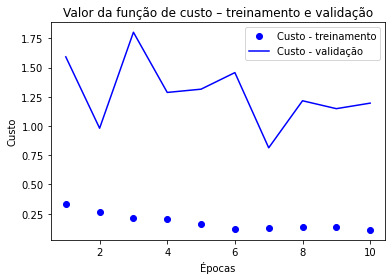

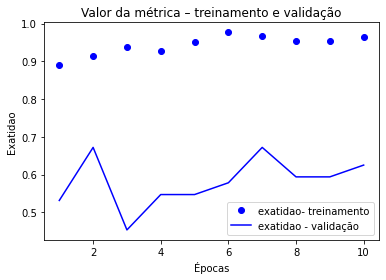

In [15]:
# Salva treinamento na variável history para visualização
history_dict2 = history2.history

# Salva custos, métricas e epocas em vetores 
custo = history_dict2['loss']
acc = history_dict2['accuracy']
val_custo = history_dict2['val_loss']
val_acc = history_dict2['val_accuracy']

# Cria vetor de épocas
epocas = range(1, len(custo) + 1)

# Gráfico dos valores de custo
plt.plot(epocas, custo, 'bo', label='Custo - treinamento')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

# Gráfico dos valores da métrica
plt.plot(epocas, acc, 'bo', label='exatidao- treinamento')
plt.plot(epocas, val_acc, 'b', label='exatidao - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [16]:
#Calculo do custo e exatidão para os dados de treinamento, validação e teste
# Calcula a função de custo e a métrica para os dados de teste
custo_metrica_train = rna.evaluate(train_generator, steps=20) 
custo_metrica_val = rna.evaluate(valid_generator, steps=20) 
custo_metrica_test = rna.evaluate(test_generator, steps=20) 

11/20 [===============>..............] - ETA: 23s - loss: 0.1043 - accuracy: 0.9676

 3/20 [===>..........................] - ETA: 36s - loss: 1.3898 - accuracy: 0.6145

20/20 [==============================] - 2s 105ms/step - loss: 0.2427 - accuracy: 0.9000
